In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [2]:
train_1 = pd.read_csv("train.csv")
test_1 = pd.read_csv("test.csv")

In [3]:
train = train_1.copy()
test = test_1.copy()

In [4]:
train['Severity'] = train['Severity'].map({"Significant_Damage_And_Fatalities":0,"Minor_Damage_And_Injuries":1,"Significant_Damage_And_Serious_Injuries":2,"Highly_Fatal_And_Damaging":3})

In [5]:
Y_train = train['Severity']
X_train = train.drop(['Severity'],axis=1)

Best alpha using built-in LassoCV: 0.162299
Best score using built-in LassoCV: 0.283694
Lasso picked 5 variables and eliminated the other 6 variables


/home/harsh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Text(0.5, 1.0, 'Feature importance using Lasso Model')

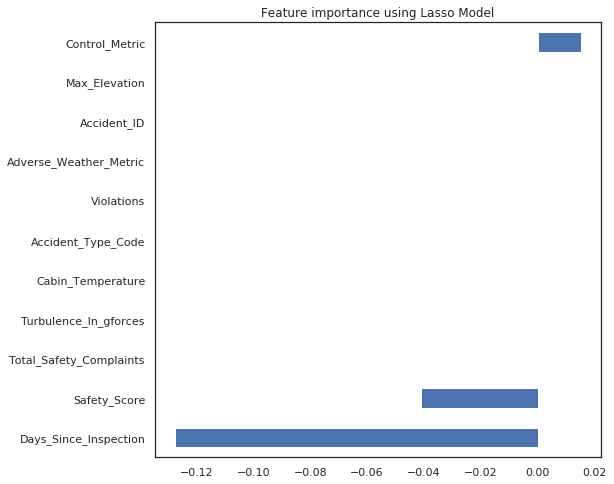

In [6]:
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X_train,Y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train,Y_train))
coef = pd.Series(reg.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,8)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=4)
fit = bestfeatures.fit(X_train,Y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)


#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns


#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

print(featureScores.nlargest(10,'Score'))

                      Specs         Score
7             Max_Elevation  37871.221260
0              Safety_Score   8552.477911
10              Accident_ID   3180.018341
3            Control_Metric   1017.270613
6        Accident_Type_Code    658.840259
9    Adverse_Weather_Metric    160.457298
2   Total_Safety_Complaints     53.652473
8                Violations     27.817094
1     Days_Since_Inspection     23.452196
4     Turbulence_In_gforces      6.544339


In [8]:
X_train.drop(['Max_Elevation','Accident_ID','Adverse_Weather_Metric','Violations','Accident_Type_Code','Cabin_Temperature','Turbulence_In_gforces','Total_Safety_Complaints'],axis=1,inplace=True)

In [10]:
kfold = StratifiedKFold(n_splits=12)

In [11]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'max_depth':[7,10,None],
              'n_estimators':[300,500,700],
              'max_features':[1,2],
               'criterion':['friedman_mse'],
               'validation_fraction':[0.2,0.3],
               'min_samples_leaf':[1,3,4,7],
                'learning_rate':[0.1,0.2],
                'warm_start':[True,False],
                'loss':['deviance'],
                'min_weight_fraction_leaf':[0],   
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_


# Best score
gsGBC.best_score_

Fitting 12 folds for each of 576 candidates, totalling 6912 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 51.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 72.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 102.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 127.4min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 149.3min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 175.7min
[Parallel(n_jobs=-1)]: Done 6912 out of 6912 | elapsed: 200.8min finished


0.9761

In [12]:
# 'max_depth':[1,3,5,10,None],
#               'n_estimators':[10,30,40,50,70,100,150,200,300,500],
#               'max_features':[1,2,3],
#                'criterion':['friedman_mse'],
#                'validation_fraction':[0.1,0.2,0.3,0.4],
#                'min_samples_leaf':[1,3,4],
#                 'learning_rate':[0.1,0.2,0.5,1,1.1],
#                 'warm_start':[True,False],
#                 'loss':['deviance'],
#            'min_weight_fraction_leaf':[0,0.1,0.2,0.3,0.4]

In [13]:
gsGBC.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 7,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_weight_fraction_leaf': 0,
 'n_estimators': 700,
 'validation_fraction': 0.2,
 'warm_start': True}

In [14]:
# Grid Search Gradient Boost Algo
# 'criterion': 'friedman_mse',
#  'learning_rate': 0.2,
#  'loss': 'deviance',
#  'max_depth': 7,
#  'max_features': 2,
#  'min_samples_leaf': 1,
#  'min_weight_fraction_leaf': 0,
#  'n_estimators': 500,
#  'validation_fraction': 0.3,
#  'warm_start': True

In [15]:
GBC_best

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=7,
                           max_features=2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0, n_estimators=700,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.2, verbose=0, warm_start=True)

In [16]:
gsGBC.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=7,
                           max_features=2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0, n_estimators=700,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.2, verbose=0, warm_start=True)

In [17]:
# from sklearn.model_selection import RandomizedSearchCV

# from scipy.stats import randint

# est =GradientBoostingClassifier()
# p_distr={'max_depth':[7,None],
#               'n_estimators':[200,300,500],
#               'max_features':[1,2,3],
#              'min_samples_split':[10,20,40,60],
#                'criterion':['friedman_mse'],
#                'validation_fraction':[0.1,0.2,0.3,0.4],
#          'subsample':[0.85,0.9,0.95,1],
#                'min_samples_leaf':[1,3,7,9],
#                'verbose':randint(1,5),
#                 'learning_rate':[0.1,0.2,0.5,1],
#                 'warm_start':[True,False],
#                 'loss':['deviance'],
                
#            'min_weight_fraction_leaf':[0,0.1,0.2,0.3,0.4],
               
#               }
# GBC = RandomizedSearchCV(est, param_distributions=p_distr,n_jobs=-1, n_iter=40, cv=10,verbose=1)
   
# GBC.fit(X_train,Y_train)

In [18]:
# GBC.best_params_

In [19]:
# GBC.best_score_

In [37]:
gbc =GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=7,
                           max_features=2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0, n_estimators=700,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.2, verbose=0, warm_start=True)
gbc.fit(X_train,Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=7,
                           max_features=2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0, n_estimators=700,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.2, verbose=0, warm_start=True)

In [21]:
# criterion= 'friedman_mse',
#  learning_rate= 0.1,
#  loss= 'deviance',
#  max_depth= 7,
#  max_features= 2,
#  min_samples_leaf= 7,
#  min_samples_split= 40,
#  min_weight_fraction_leaf= 0,
#  n_estimators= 500,
#  subsample= 0.95,
#  validation_fraction= 0.2,
#  verbose= 3,
#  warm_start = True)

In [22]:
# 87.64 %
# criterion= 'friedman_mse',
#  learning_rate= 0.2,
#  loss= 'deviance',
#  max_depth= 7,

#  max_features= 2,
#  min_samples_leaf= 1,
#  min_samples_split= 40,
#  min_weight_fraction_leaf= 0,
#  n_estimators= 500,
#  subsample= 0.95,
#  validation_fraction= 0.2,
#  verbose= 3,
#  warm_start = True)

In [23]:
# criterion= 'friedman_mse',
#  learning_rate= 0.2,
#  loss= 'deviance',
#  max_depth= 7,
#  max_features= 2,
#  min_samples_leaf= 1,
#  min_samples_split= 40,
#  min_weight_fraction_leaf= 0,
#  n_estimators= 5000,
#  subsample= 0.95,
#  validation_fraction= 0.2,
#  verbose= 3,
#  warm_start= True)

In [38]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X_train.values,Y_train.values)

In [39]:
Y_pred = gbc.predict(x_test)

In [40]:
from sklearn import metrics 
print("Acc :",metrics.accuracy_score(y_test,Y_pred))

Acc : 1.0


In [41]:
# 87.56 %

# criterion= 'friedman_mse',
#  learning_rate= 0.2,
#  loss= 'deviance',
#  max_depth= 7,
#  max_features= 2,
#  min_samples_leaf= 1,
#  min_samples_split= 40,
#  min_weight_fraction_leaf= 0,
#  n_estimators= 150,
#  subsample= 0.95,
#  validation_fraction= 0.2,
#  verbose= 3,
#  warm_start= False)

In [28]:
test.drop(['Max_Elevation','Adverse_Weather_Metric','Violations','Accident_Type_Code','Cabin_Temperature','Turbulence_In_gforces','Total_Safety_Complaints','Accident_ID'],axis=1,inplace=True)

In [42]:
x=test.values

In [43]:
y_pred = gbc.predict(x)

In [44]:
sub = test_1['Accident_ID']

In [45]:
sub = pd.DataFrame(sub)

In [46]:
sub['Severity'] = y_pred

In [47]:
sub['Severity'] = sub['Severity'].map({0:"Significant_Damage_And_Fatalities",1:"Minor_Damage_And_Injuries",2:"Significant_Damage_And_Serious_Injuries",3:"Highly_Fatal_And_Damaging"})

In [48]:
sub.to_csv("Gradient_boost_last_final_.csv",index=False)

In [49]:
sub.head()

,Accident_ID,Severity
0,1,Highly_Fatal_And_Damaging
1,10,Significant_Damage_And_Fatalities
2,14,Significant_Damage_And_Serious_Injuries
3,17,Minor_Damage_And_Injuries
4,21,Significant_Damage_And_Fatalities
